# PRT840 – IT Thesis

In [2]:
# <------------------- Imports & configuration --------------------------->
import os
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

# For saving trained artifacts
import joblib

# Matplotlib defaults (no specific colors/styles as per requirement)
plt.rcParams.update({'figure.figsize': (8, 5)})


In [ ]:
# <.------------------------ Paths & utility ----------------------------->
DEFAULT_DATASET_PATH = "dataset.csv"

# If you run this notebook locally, replace this with your local path or put dataset.csv in the same folder.
LOCAL_FALLBACK_PATH = "dataset.csv"
COLAB_SAMPLE_DATA_PATH = "/content/sample_data/dataset.csv"

# A robust loader for KDD'99 variants (with/without header; with/without 'difficulty' column)
KDD_COLS = [
    "duration","protocol_type","service","flag","src_bytes","dst_bytes","land","wrong_fragment","urgent",
    "hot","num_failed_logins","logged_in","num_compromised","root_shell","su_attempted","num_root",
    "num_file_creations","num_shells","num_access_files","num_outbound_cmds","is_host_login","is_guest_login",
    "count","srv_count","serror_rate","srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
    "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count","dst_host_same_srv_rate",
    "dst_host_diff_srv_rate","dst_host_same_src_port_rate","dst_host_srv_diff_host_rate","dst_host_serror_rate",
    "dst_host_srv_serror_rate","dst_host_rerror_rate","dst_host_srv_rerror_rate","label"
]

def load_kdd_dataset():
    paths_to_try = [DEFAULT_DATASET_PATH, LOCAL_FALLBACK_PATH, COLAB_SAMPLE_DATA_PATH]
    last_err = None
    for p in paths_to_try:
        try:
            # Try with header inference first
            df = pd.read_csv(p, low_memory=False)
            label_col = None

            # If there is clearly no header (i.e., many unnamed columns), try loading without header
            if all(str(c).startswith('Unnamed') for c in df.columns):
                df = pd.read_csv(p, header=None, low_memory=False)

            # Determine label column
            columns = list(df.columns)
            if 'label' in columns:
                label_col = 'label'
            elif 'class' in columns:
                label_col = 'class'
            else:
                # Assume last column is label
                label_col = columns[-1]

            # If we have exactly 42 columns and no meaningful names, assign KDD names
            if len(df.columns) in (41, 42, 43):  # allow small variants
                # If numeric column names or generic strings, map to KDD_COLS when length matches
                if len(df.columns) == 42:
                    # Assign names if they don't already match expected
                    if set(df.columns) != set(KDD_COLS):
                        df.columns = KDD_COLS
                        label_col = 'label'
                elif len(df.columns) == 43:
                    # Some versions include an extra 'difficulty' column; drop if present
                    # Try to assign standard names first
                    cols43 = KDD_COLS[:-1] + ['difficulty', KDD_COLS[-1]]
                    if len(df.columns) == len(cols43):
                        df.columns = cols43
                        if 'difficulty' in df.columns:
                            df = df.drop(columns=['difficulty'])
                        label_col = 'label'
                elif len(df.columns) == 41:
                    # Rare case: missing one column; keep as-is and assume last col is label
                    pass

            # Clean label values: strip trailing dots; map to binary 'attack' vs 'normal'
            df[label_col] = df[label_col].astype(str).str.strip().str.lower().str.replace('.', '', regex=False)
            df['target'] = np.where(df[label_col] == 'normal', 'normal', 'attack')

            # Drop the original label if its name isn't 'target'
            if label_col != 'target' and 'target' in df.columns:
                # Keep the original label as 'raw_label' for reference
                if label_col in df.columns:
                    df = df.rename(columns={label_col: 'raw_label'})
            return df, 'target'
        except Exception as e:
            last_err = e
            continue
    raise FileNotFoundError(f"Could not load dataset from any known path. Last error: {last_err}")

# Load Data

In [4]:
df, LABEL_COL = load_kdd_dataset()
print("Data shape:", df.shape)
df.head()

Data shape: (75603, 33)


,Unnamed: 0,duration,protocol_type,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,raw_label,target
0,0,0,1,0,181,5450,0,0,0,0,...,1.0,0.0,0.0,9.0,9.0,0.0,0.11,0.0,normal,normal
1,1,0,1,0,239,486,0,0,0,0,...,1.0,0.0,0.0,19.0,19.0,0.0,0.05,0.0,normal,normal
2,2,0,1,0,235,1337,0,0,0,0,...,1.0,0.0,0.0,29.0,29.0,0.0,0.03,0.0,normal,normal
3,3,0,1,0,219,1337,0,0,0,0,...,1.0,0.0,0.0,39.0,39.0,0.0,0.03,0.0,normal,normal
4,4,0,1,0,217,2032,0,0,0,0,...,1.0,0.0,0.0,49.0,49.0,0.0,0.02,0.0,normal,normal


# EDA and Graphs + KDE

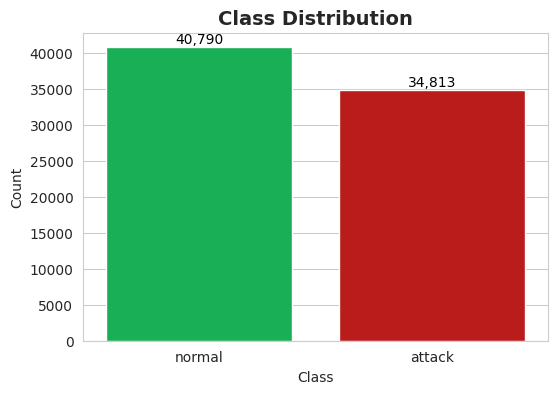

Class distribution (%):
target
normal    53.95
attack    46.05
Name: count, dtype: float64


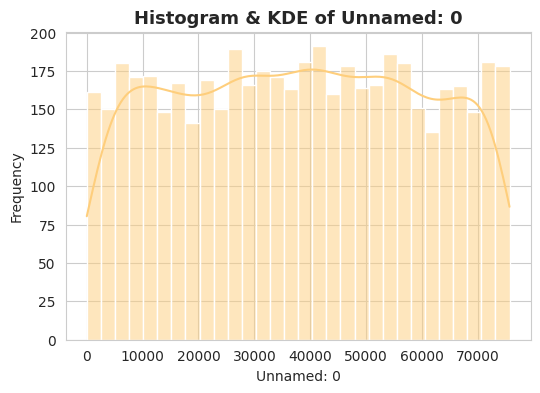

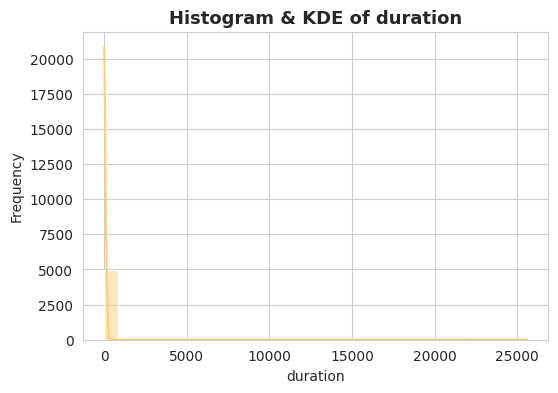

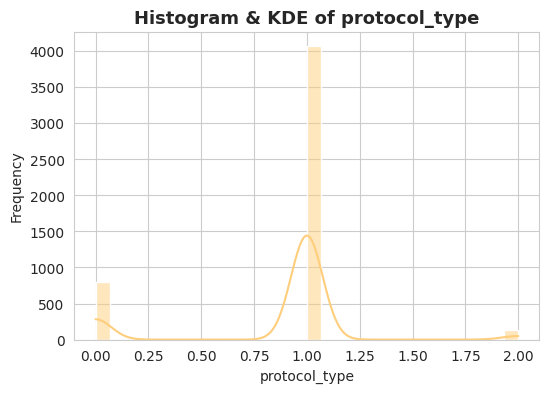

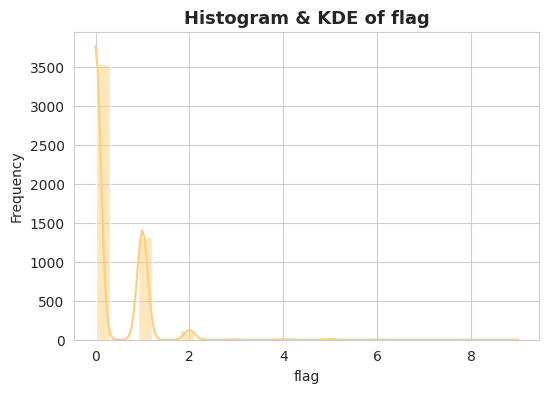

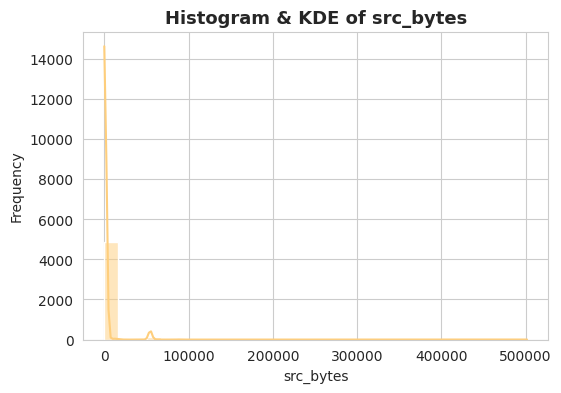

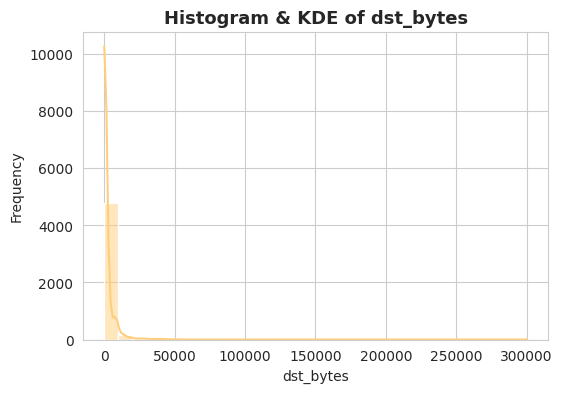

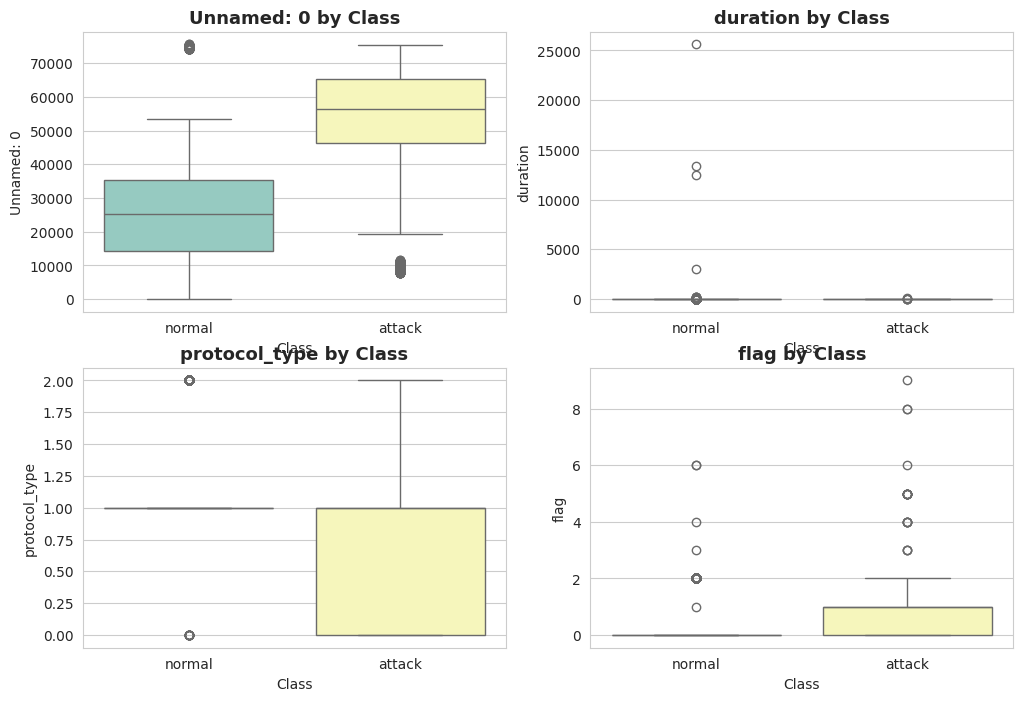

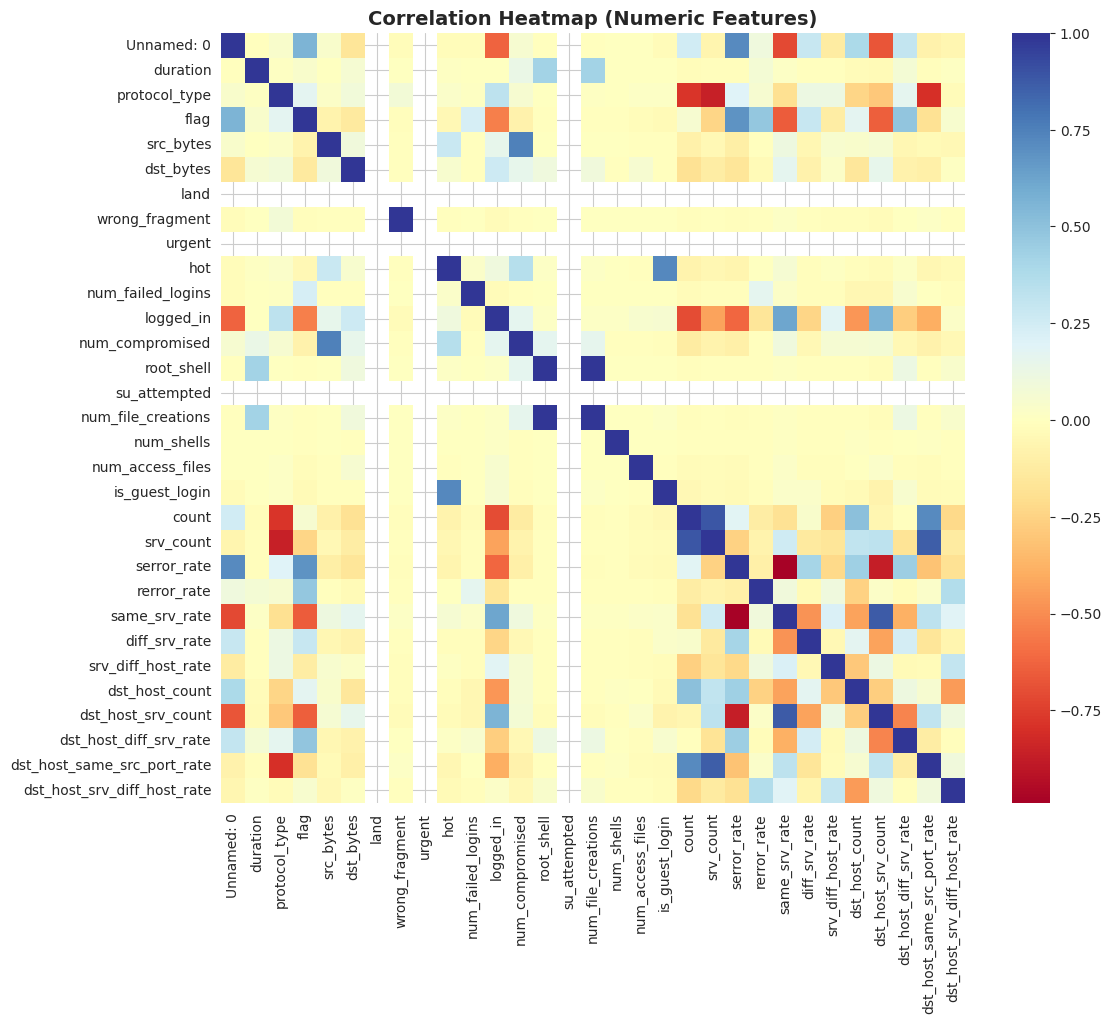

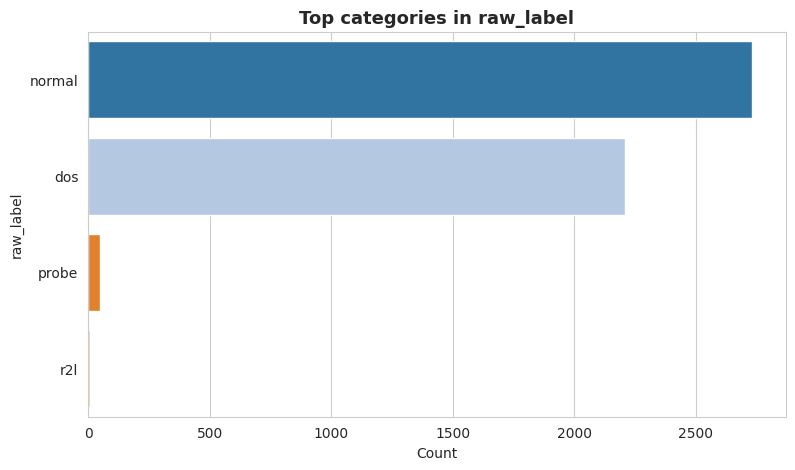

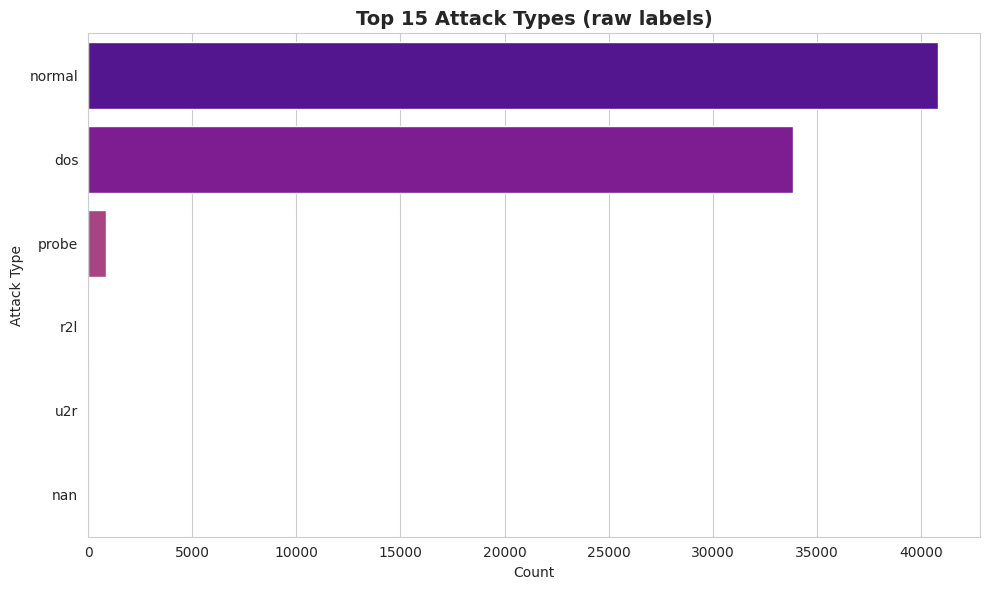

<Figure size 800x500 with 0 Axes>

In [5]:
import seaborn as sns

# Use bright seaborn style
sns.set_style("whitegrid")

# Define vibrant palettes
palette_class = ["#00C853", "#D50000"]  # Bright green vs bright red
palette_hist = "Spectral"                   # Rainbow colors for histograms
palette_box = "Set3"                        # Colorful pastel boxplots
palette_corr = "RdYlBu"                     # Strong diverging for heatmap
palette_cat = "tab20"                       # 20 distinct colors for categorical
palette_attack = "plasma"                   # Purple-yellow gradient for attacks

# 1. Class balance
class_counts = df[LABEL_COL].value_counts()
plt.figure(figsize=(6,4))
sns.barplot(x=class_counts.index, y=class_counts.values, palette=palette_class)
plt.title("Class Distribution", fontsize=14, weight="bold")
plt.xlabel("Class")
plt.ylabel("Count")
for i, v in enumerate(class_counts.values):
    plt.text(i, v + 500, f"{v:,}", ha='center', fontsize=10, color="black")
plt.show()

print("Class distribution (%):")
print((class_counts / len(df) * 100).round(2))

# 2. Distribution of numeric features (histogram + KDE)
num_cols = [c for c in df.columns if df[c].dtype != 'object' and c != LABEL_COL]
sampled = df.sample(5000, random_state=42)  # sample for faster plotting

for col in num_cols[:6]:  # limit to first 6 numeric features
    plt.figure(figsize=(6,4))
    sns.histplot(sampled[col], bins=30, kde=True,
                 color=sns.color_palette(palette_hist, 10)[3])
    plt.title(f"Histogram & KDE of {col}", fontsize=13, weight="bold")
    plt.xlabel(col)
    plt.ylabel("Frequency")

# 3. Boxplots of selected numeric features by target (arranged in 2 columns)
n_cols = 2
n_features = len(num_cols[:4])   # adjust slice if you want more features
n_rows = (n_features + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 4 * n_rows))

for i, col in enumerate(num_cols[:4]):
    ax = axes[i // n_cols, i % n_cols] if n_rows > 1 else axes[i % n_cols]
    sns.boxplot(x=df[LABEL_COL], y=sampled[col], palette=palette_box, ax=ax)
    ax.set_title(f"{col} by Class", fontsize=13, weight="bold")
    ax.set_xlabel("Class")
    ax.set_ylabel(col)

# 4. Correlation heatmap of numeric features
corr = sampled[num_cols].corr()
plt.figure(figsize=(12,10))
sns.heatmap(corr, cmap=palette_corr, center=0, annot=False, cbar=True)
plt.title("Correlation Heatmap (Numeric Features)", fontsize=14, weight="bold")

# 5. Categorical feature distributions
cat_cols = [c for c in df.columns if df[c].dtype == 'object' and c != LABEL_COL]

for col in cat_cols[:3]:  # limit to first 3 categorical features
    plt.figure(figsize=(9,5))
    sns.countplot(y=col, data=sampled,
                  order=sampled[col].value_counts().index[:10],
                  palette=sns.color_palette(palette_cat, 10))
    plt.title(f"Top categories in {col}", fontsize=13, weight="bold")
    plt.xlabel("Count")
    plt.ylabel(col)

# 6. Attack types distribution (if available in original raw_label column)
if "raw_label" in df.columns:
    attack_counts = df['raw_label'].value_counts().head(15)
    plt.figure(figsize=(10,6))
    sns.barplot(y=attack_counts.index, x=attack_counts.values,
                palette=sns.color_palette(palette_attack, len(attack_counts)))
    plt.title("Top 15 Attack Types (raw labels)", fontsize=14, weight="bold")
    plt.xlabel("Count")
    plt.ylabel("Attack Type")

    plt.tight_layout()  # Optimize layout to avoid overlap
plt.show()  # Render the plots

# Hide any unused subplots if n_features is odd
for j in range(i + 1, n_rows * n_cols):
    fig.delaxes(axes[j // n_cols, j % n_cols] if n_rows > 1 else axes[j % n_cols])

plt.tight_layout()
plt.show()

In [6]:
cols="""duration,
protocol_type,
service,
flag,
src_bytes,
dst_bytes,
land,
wrong_fragment,
urgent,
hot,
num_failed_logins,
logged_in,
num_compromised,
root_shell,
su_attempted,
num_root,
num_file_creations,
num_shells,
num_access_files,
num_outbound_cmds,
is_host_login,
is_guest_login,
count,
srv_count,
serror_rate,
srv_serror_rate,
rerror_rate,
srv_rerror_rate,
same_srv_rate,
diff_srv_rate,
srv_diff_host_rate,
dst_host_count,
dst_host_srv_count,
dst_host_same_srv_rate,
dst_host_diff_srv_rate,
dst_host_same_src_port_rate,
dst_host_srv_diff_host_rate,
dst_host_serror_rate,
dst_host_srv_serror_rate,
dst_host_rerror_rate,
dst_host_srv_rerror_rate"""

columns=[]
for c in cols.split(','):
    if(c.strip()):
       columns.append(c.strip())

columns.append('target')
#print(columns)
print(len(columns))

42


In [7]:
# Define attacks_types dictionary before printing
attacks_types = {
    'normal': 'normal',
    'back': 'dos',
    'buffer_overflow': 'u2r',
    'ftp_write': 'r2l',
    'guess_passwd': 'r2l',
    'imap': 'r2l',
    'ipsweep': 'probe',
    'land': 'dos',
    'loadmodule': 'u2r',
    'multihop': 'r2l',
    'neptune': 'dos',
    'nmap': 'probe',
    'perl': 'u2r',
    'phf': 'r2l',
    'pod': 'dos',
    'portsweep': 'probe',
    'rootkit': 'u2r',
    'satan': 'probe',
    'smurf': 'dos',
    'spy': 'r2l',
    'teardrop': 'dos',
    'warezclient': 'r2l',
    'warezmaster': 'r2l',
}

# Print attack_types mapping in "key value" format (space separated)
for k, v in attacks_types.items():
    if k != 'normal':  # skip 'normal' if you want only attacks
        print(f"{k} {v}")

back dos
buffer_overflow u2r
ftp_write r2l
guess_passwd r2l
imap r2l
ipsweep probe
land dos
loadmodule u2r
multihop r2l
neptune dos
nmap probe
perl u2r
phf r2l
pod dos
portsweep probe
rootkit u2r
satan probe
smurf dos
spy r2l
teardrop dos
warezclient r2l
warezmaster r2l


In [8]:
# Fixes:
# 1. Correct path to dataset.csv (handled by load_kdd_dataset)
# 2. Use correct mapping for attacks_types (no need for r[:-1], just r)
# 3. Make sure 'target' column values match keys in attacks_types

# Use the robust loader function
df, LABEL_COL = load_kdd_dataset()

# Adding Attack Type column
# Ensure 'raw_label' exists for mapping, which load_kdd_dataset does if the original label wasn't 'target'
if 'raw_label' in df.columns:
    df['Attack Type'] = df['raw_label'].apply(lambda r: attacks_types.get(r, 'unknown'))
    # If you no longer need the 'raw_label' column, you can drop it
    # df = df.drop(columns=['raw_label'])
elif LABEL_COL in df.columns:
     # Fallback if raw_label is not present but LABEL_COL is the original
     df['Attack Type'] = df[LABEL_COL].apply(lambda r: attacks_types.get(r, 'unknown'))


# Optional: Check for unmapped values
unmapped = df.loc[df['Attack Type'] == 'unknown', df.columns[df.columns.str.contains('label|target')].tolist()].stack().unique()
if len(unmapped) > 0:
    print("Unmapped target values:", unmapped)

# Display the first few rows to verify the changes
display(df.head())

Unmapped target values: ['u2r' 'attack' 'dos' 'r2l' 'probe' 'nan']


,Unnamed: 0,duration,protocol_type,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,raw_label,target,Attack Type
0,0,0,1,0,181,5450,0,0,0,0,...,0.0,0.0,9,9,0.0,0.11,0.0,normal,normal,normal
1,1,0,1,0,239,486,0,0,0,0,...,0.0,0.0,19,19,0.0,0.05,0.0,normal,normal,normal
2,2,0,1,0,235,1337,0,0,0,0,...,0.0,0.0,29,29,0.0,0.03,0.0,normal,normal,normal
3,3,0,1,0,219,1337,0,0,0,0,...,0.0,0.0,39,39,0.0,0.03,0.0,normal,normal,normal
4,4,0,1,0,217,2032,0,0,0,0,...,0.0,0.0,49,49,0.0,0.02,0.0,normal,normal,normal


In [9]:
df.shape

(107561, 34)

In [10]:
# To get the output with trailing dots (original labels), use the raw column before any cleaning:

# If you loaded with custom column names and your original labels are in 'target':
print(df['target'].value_counts())
print(df['Attack Type'].value_counts())
df.dtypes

target
normal    60147
attack    47414
Name: count, dtype: int64
Attack Type
normal     60147
unknown    47414
Name: count, dtype: int64


,0
Unnamed: 0,int64
duration,int64
protocol_type,int64
flag,int64
src_bytes,int64
dst_bytes,int64
land,int64
wrong_fragment,int64
urgent,int64
hot,int64


In [11]:
df.isnull().sum()

,0
Unnamed: 0,0
duration,0
protocol_type,0
flag,0
src_bytes,0
dst_bytes,0
land,0
wrong_fragment,0
urgent,0
hot,0


In [12]:
# Finding categorical features
num_cols = df._get_numeric_data().columns

# Only keep columns with dtype 'object' (categorical)
cate_cols = [col for col in df.columns if df[col].dtype == 'object']

# Remove 'target' and 'Attack Type' if present
for col in ['target', 'Attack Type']:
    if col in cate_cols:
        cate_cols.remove(col)

cate_cols

['raw_label']

In [13]:
# To display the grouped attack type counts:
print(df['Attack Type'].value_counts())

Attack Type
normal     60147
unknown    47414
Name: count, dtype: int64


# Scatter plots to analyze the relationships between key variables

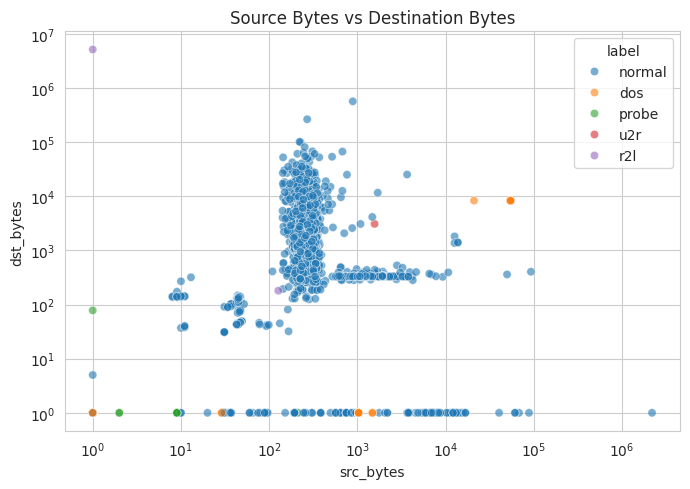

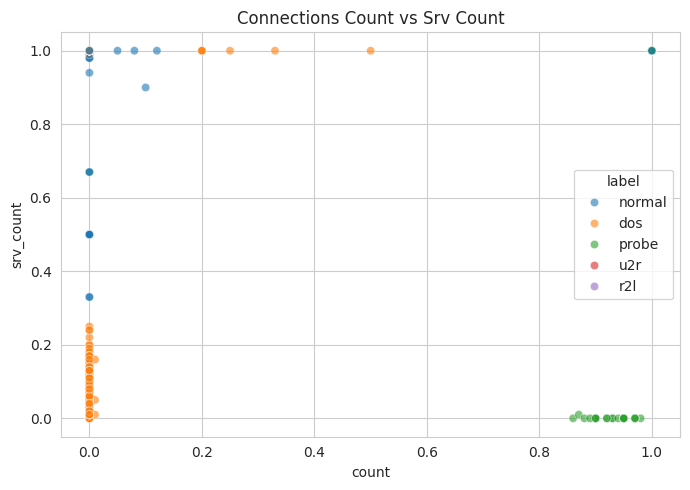

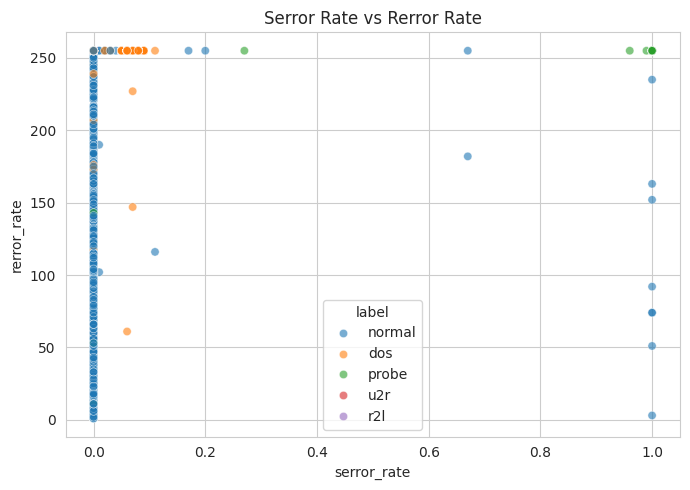

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1) Load your data (CSV or GZ both supported) ---
# Change this filename if needed
path = "/content/sample_data/dataset.csv"  # or "dataset.gz"
compression = "infer"  # works for .csv and .gz
df = pd.read_csv(path, header=None, compression=compression)

# --- 2) Assign flexible column names ---
# KDD'99 has 41 features + 1 label. We'll map as many as exist, and force the last col to be 'label'.
kdd_features = [
    "duration", "protocol_type", "service", "flag", "src_bytes", "dst_bytes",
    "land", "wrong_fragment", "urgent", "hot", "num_failed_logins", "logged_in",
    "num_compromised", "root_shell", "su_attempted", "num_root", "num_file_creations",
    "num_shells", "num_access_files", "num_outbound_cmds", "is_host_login", "is_guest_login",
    "count", "srv_count", "serror_rate", "srv_serror_rate", "rerror_rate", "srv_rerror_rate",
    "same_srv_rate", "diff_srv_rate", "srv_diff_host_rate", "dst_host_count", "dst_host_srv_count",
    "dst_host_same_srv_rate", "dst_host_diff_srv_rate", "dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate", "dst_host_serror_rate", "dst_host_srv_serror_rate",
    "dst_host_rerror_rate", "dst_host_srv_rerror_rate",
]
n_cols = df.shape[1]
if n_cols < 2:
    raise ValueError("Expected at least 2 columns (features + label).")

feature_count = n_cols - 1
assigned = kdd_features[:feature_count] + ["label"]
df.columns = assigned

# --- 3) Build a plotting sample & type fixes ---
df_plot = df.sample(n=min(5000, len(df)), random_state=42).copy()

# Columns we hope to plot (only those that exist will be used)
wanted = ["src_bytes", "dst_bytes", "count", "srv_count", "serror_rate", "rerror_rate", "label"]
existing = [c for c in wanted if c in df_plot.columns]

# Coerce numeric where relevant
for c in ["src_bytes", "dst_bytes", "count", "srv_count", "serror_rate", "rerror_rate"]:
    if c in df_plot.columns:
        df_plot[c] = pd.to_numeric(df_plot[c], errors="coerce")

# Drop rows with NaNs in the columns needed for each plot on a per-plot basis later

# Avoid log(0) for byte columns if they exist
for c in ["src_bytes", "dst_bytes"]:
    if c in df_plot.columns:
        df_plot[c] = df_plot[c].clip(lower=0) + 1

label_col = "label"  # we set it explicitly above

# --- 4) Helper to safely plot only if both axes exist ---
def safe_scatter(data, x, y, title, logx=False, logy=False, hue=label_col):
    if x not in data.columns or y not in data.columns or hue not in data.columns:
        print(f"Skipping: missing columns for '{title}' -> need [{x}, {y}, {hue}]")
        return
    d = data.dropna(subset=[x, y, hue]).copy()
    if d.empty:
        print(f"Skipping: no data after dropna for '{title}'")
        return
    plt.figure(figsize=(7, 5))
    sns.scatterplot(data=d, x=x, y=y, hue=hue, alpha=0.6)
    plt.title(title)
    if logx:
        plt.xscale("log")
    if logy:
        plt.yscale("log")
    plt.tight_layout()
    plt.show()

# --- 5) Your three plots (drawn only if columns are present) ---
safe_scatter(df_plot, "src_bytes", "dst_bytes", "Source Bytes vs Destination Bytes", logx=True, logy=True)
safe_scatter(df_plot, "count", "srv_count", "Connections Count vs Srv Count")
safe_scatter(df_plot, "serror_rate", "rerror_rate", "Serror Rate vs Rerror Rate")


In [15]:
# Reload the dataset using the robust loader to ensure 'target' column is present
df, LABEL_COL = load_kdd_dataset()

# Ensure df has the 'target' column from cell 5182dcff
# This is necessary if df was overwritten in subsequent cells
if 'raw_label' in df.columns and 'target' not in df.columns:
    df['target'] = df['raw_label'].apply(lambda r: attacks_types.get(r.strip().lower().replace('.', ''), 'unknown'))
    df['target'] = df['target'].apply(lambda x: 'normal' if x == 'normal' else 'attack')
elif LABEL_COL in df.columns and 'target' not in df.columns:
     df['target'] = df[LABEL_COL].apply(lambda r: attacks_types.get(str(r).strip().lower().replace('.', ''), 'unknown'))
     df['target'] = df['target'].apply(lambda x: 'normal' if x == 'normal' else 'attack')


# X contains all features, y contains the target label
# Use the 'target' column created in cell 5182dcff for y
X = df.drop(columns=['target']) # Use the 'target' column for dropping
y = df['target']

# Only drop rows where the target is null - although isnull().sum() showed no nulls, this is defensive
mask = y.notnull()
X = X[mask]
y = y[mask]

print(f"After cleaning: X shape = {X.shape}, y shape = {y.shape}")

# Identify categorical vs numeric automatically
# Exclude 'raw_label' as it's just the original string label
cat_cols = [c for c in X.columns if X[c].dtype == 'object' and c != 'raw_label']
num_cols = [c for c in X.columns if c not in cat_cols and c != 'raw_label']


print(f"Categorical columns: {cat_cols[:10]}{'...' if len(cat_cols) > 10 else ''}")
print(f"Numeric columns: {num_cols[:10]}{'...' if len(num_cols) > 10 else ''}")


# ColumnTransformer: scale numeric (without centering for sparse safety), one-hot encode categorical
# Add SimpleImputer to handle potential NaN values in numeric features
from sklearn.impute import SimpleImputer

preprocessor = ColumnTransformer(
    transformers=[
        ("num", Pipeline([('imputer', SimpleImputer(strategy='median')), ('scaler', StandardScaler(with_mean=False))]), num_cols),
        ("cat", OneHotEncoder(handle_unknown='ignore'), cat_cols)
    ],
    remainder='drop'
)

After cleaning: X shape = (140192, 32), y shape = (140192,)
Categorical columns: []
Numeric columns: ['Unnamed: 0', 'duration', 'protocol_type', 'flag', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot']...


# Evaluation Function

In [16]:
def evaluate_model(name, pipeline, X_test, y_test, results):
    preds = pipeline.predict(X_test)
    acc = accuracy_score(y_test, preds)
    prec = precision_score(y_test, preds, pos_label='attack', zero_division=0)
    rec = recall_score(y_test, preds, pos_label='attack', zero_division=0)
    f1 = f1_score(y_test, preds, pos_label='attack', zero_division=0)
    print(f"\n=== {name} ===")
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1-score : {f1:.4f}")
    print("\nClassification report:")
    print(classification_report(y_test, preds, zero_division=0))

    # Confusion matrix plot
    cm = confusion_matrix(y_test, preds, labels=['normal','attack'])
    fig = plt.figure()
    plt.imshow(cm, interpolation='nearest')
    plt.title(f"Confusion Matrix – {name}")
    plt.xticks([0,1], ['normal','attack'])
    plt.yticks([0,1], ['normal','attack'])
    for (i, j), v in np.ndenumerate(cm):
        plt.text(j, i, str(v), ha='center', va='center')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()

    results.append({
        'model': name,
        'accuracy': acc,
        'precision_attack': prec,
        'recall_attack': rec,
        'f1_attack': f1
    })


# Models

Logistic Regression

Categorical columns: []
Numeric columns: ['Unnamed: 0', 'duration', 'protocol_type', 'flag', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot']...
Training Logistic Regression...

=== Logistic Regression ===
Accuracy : 0.9969
Precision: 0.9979
Recall   : 0.9963
F1-score : 0.9971

Classification report:
              precision    recall  f1-score   support

      attack       1.00      1.00      1.00     15155
      normal       1.00      1.00      1.00     12884

    accuracy                           1.00     28039
   macro avg       1.00      1.00      1.00     28039
weighted avg       1.00      1.00      1.00     28039



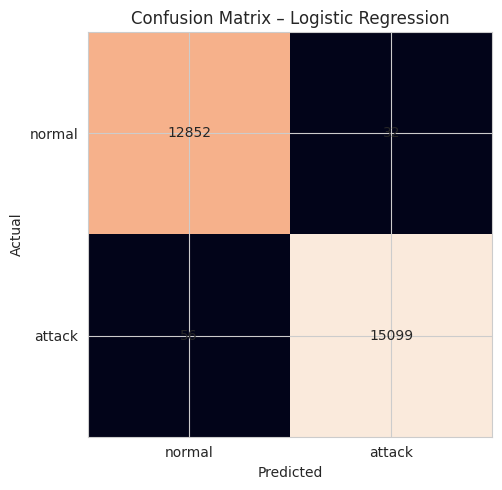

In [17]:
print(f"Categorical columns: {cat_cols[:10]}{'...' if len(cat_cols) > 10 else ''}")
print(f"Numeric columns: {num_cols[:10]}{'...' if len(num_cols) > 10 else ''}")

# Split data for training/testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

log_reg = Pipeline(steps=[
    ('prep', preprocessor),
    ('clf', LogisticRegression(max_iter=1000, class_weight='balanced', solver='saga', n_jobs=1))
])

print("Training Logistic Regression...")
log_reg.fit(X_train, y_train)

results = []
evaluate_model("Logistic Regression", log_reg, X_test, y_test, results)


Decision Tree

Training Decision Tree...

=== Decision Tree ===
Accuracy : 0.9990
Precision: 0.9991
Recall   : 0.9991
F1-score : 0.9991

Classification report:
              precision    recall  f1-score   support

      attack       1.00      1.00      1.00     15155
      normal       1.00      1.00      1.00     12884

    accuracy                           1.00     28039
   macro avg       1.00      1.00      1.00     28039
weighted avg       1.00      1.00      1.00     28039



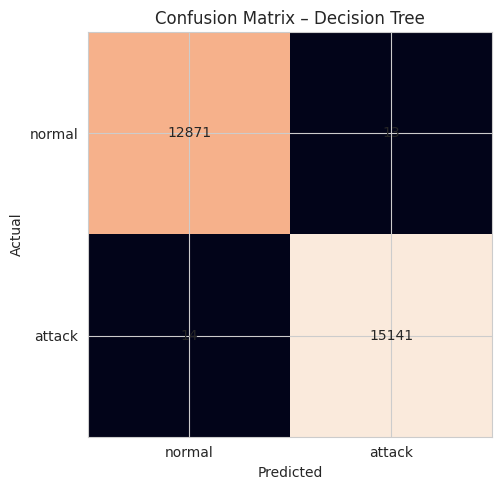

In [18]:
dt = Pipeline(steps=[
    ('prep', preprocessor),
    ('clf', DecisionTreeClassifier(random_state=42, class_weight='balanced', max_depth=None))
])

print("Training Decision Tree...")
dt.fit(X_train, y_train)

evaluate_model("Decision Tree", dt, X_test, y_test, results)


Random Forest

Training Random Forest...

=== Random Forest ===
Accuracy : 0.9995
Precision: 0.9999
Recall   : 0.9993
F1-score : 0.9996

Classification report:
              precision    recall  f1-score   support

      attack       1.00      1.00      1.00     15155
      normal       1.00      1.00      1.00     12884

    accuracy                           1.00     28039
   macro avg       1.00      1.00      1.00     28039
weighted avg       1.00      1.00      1.00     28039



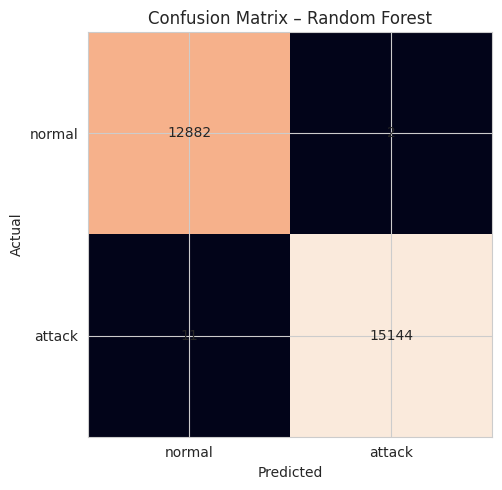

In [19]:
rf = Pipeline(steps=[
    ('prep', preprocessor),
    ('clf', RandomForestClassifier(
        n_estimators=200, random_state=42, n_jobs=-1, class_weight='balanced_subsample'
    ))
])

print("Training Random Forest...")
rf.fit(X_train, y_train)

evaluate_model("Random Forest", rf, X_test, y_test, results)


# Results summary

In [20]:
res_df = pd.DataFrame(results).sort_values('f1_attack', ascending=False)
print(res_df)
res_path = "results_metrics.csv"
res_df.to_csv(res_path, index=False)
print(f"Saved metrics to {res_path}")


                 model  accuracy  precision_attack  recall_attack  f1_attack
2        Random Forest  0.999536          0.999868       0.999274   0.999571
1        Decision Tree  0.999037          0.999142       0.999076   0.999109
0  Logistic Regression  0.996862          0.997885       0.996305   0.997094
Saved metrics to results_metrics.csv


# Feature Extraction (Random Forest)
Extract feature names after preprocessing

In [21]:
# --- Feature importance (Random Forest) ---
# Extract feature names after preprocessing
try:
    prep = rf.named_steps['prep']
    feature_names = []
    # Numeric names
    if hasattr(prep.transformers_[0][2], '__iter__'):
        feature_names.extend(prep.transformers_[0][2])
    # Categorical names
    ohe = prep.named_transformers_['cat']
    ohe_names = ohe.get_feature_names_out(prep.transformers_[1][2]).tolist()
    feature_names.extend(ohe_names)

    clf = rf.named_steps['clf']
    importances = clf.feature_importances_
    fi = pd.Series(importances, index=feature_names).sort_values(ascending=False).head(20)
    print(fi)

    plt.figure()
    fi[::-1].plot(kind='barh')
    plt.title("Top 20 Feature Importances (Random Forest)")
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.show()
except Exception as e:
    print("Could not compute feature importances with names:", e)


Could not compute feature importances with names: This OneHotEncoder instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.


# Hyperparameter Tuning with GridSearchCV

Best parameters (Logistic Regression): {'clf__C': 0.01, 'clf__solver': 'liblinear'}

=== Logistic Regression (Tuned) ===
Accuracy : 0.9967
Precision: 0.9976
Recall   : 0.9964
F1-score : 0.9970

Classification report:
              precision    recall  f1-score   support

      attack       1.00      1.00      1.00     15155
      normal       1.00      1.00      1.00     12884

    accuracy                           1.00     28039
   macro avg       1.00      1.00      1.00     28039
weighted avg       1.00      1.00      1.00     28039



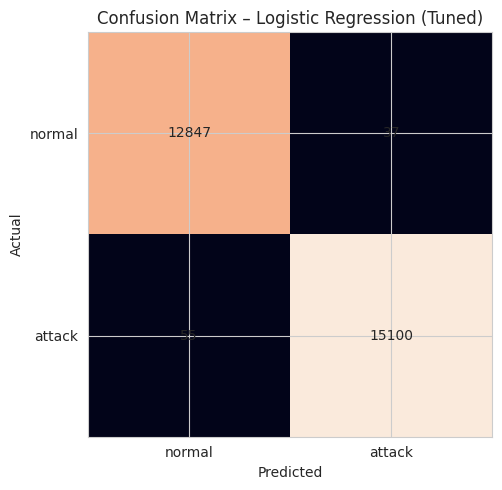

In [22]:
from sklearn.model_selection import GridSearchCV

# Example: Logistic Regression tuning
param_grid_lr = {
    "clf__C": [0.01, 0.1, 1, 10],
    "clf__solver": ["liblinear", "saga"]
}
grid_lr = GridSearchCV(log_reg, param_grid_lr, cv=3, scoring="f1", n_jobs=-1)
grid_lr.fit(X_train, y_train)

print("Best parameters (Logistic Regression):", grid_lr.best_params_)
evaluate_model("Logistic Regression (Tuned)", grid_lr.best_estimator_, X_test, y_test, results)


In [23]:
from sklearn.model_selection import cross_val_score

# Example: Random Forest cross-validation
cv_scores = cross_val_score(rf, X, y, cv=5, scoring="f1_macro", n_jobs=-1)
print("Random Forest CV F1 scores:", cv_scores)
print("Mean F1:", cv_scores.mean())


Random Forest CV F1 scores: [0.93507361 1.         0.99225403 0.99938961 0.99755883]
Mean F1: 0.9848552171653031


# Model: XGBoost

In [24]:
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline

# Encode y for XGBoost
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

# XGBoost pipeline (no change to X, only y)
xgb = Pipeline(steps=[
    ('prep', preprocessor),
    ('clf', XGBClassifier(use_label_encoder=False, eval_metric="logloss"))
])
xgb.fit(X_train, y_train_enc)

# Evaluate using decoded predictions for consistency
preds = xgb.predict(X_test)
preds_decoded = le.inverse_transform(preds)
print("\n=== XGBoost ===")
print(classification_report(y_test, preds_decoded, zero_division=0))

from sklearn.metrics import accuracy_score, f1_score
# Example: Custom metric - Balanced Accuracy
def balanced_accuracy(y_true, y_pred):
    from sklearn.metrics import recall_score
    recall_per_class = recall_score(y_true, y_pred, average=None, zero_division=0)
    return np.mean(recall_per_class)


=== XGBoost ===
              precision    recall  f1-score   support

      attack       1.00      1.00      1.00     15155
      normal       1.00      1.00      1.00     12884

    accuracy                           1.00     28039
   macro avg       1.00      1.00      1.00     28039
weighted avg       1.00      1.00      1.00     28039



# Random Forest + SMOTE


=== Random Forest + SMOTE ===
Accuracy : 0.9996
Precision: 0.9999
Recall   : 0.9993
F1-score : 0.9996

Classification report:
              precision    recall  f1-score   support

      attack       1.00      1.00      1.00     15155
      normal       1.00      1.00      1.00     12884

    accuracy                           1.00     28039
   macro avg       1.00      1.00      1.00     28039
weighted avg       1.00      1.00      1.00     28039



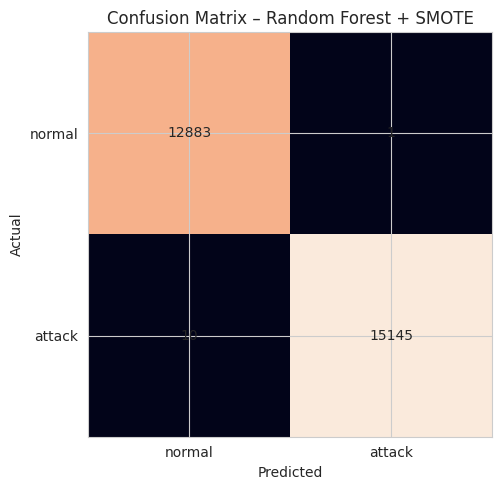

In [25]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline

# Example: SMOTE + Random Forest
smote_rf = ImbPipeline(steps=[
    ('prep', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('clf', RandomForestClassifier(n_estimators=200, random_state=42))
])
# ...existing code...
smote_rf.fit(X_train, y_train)
evaluate_model("Random Forest + SMOTE", smote_rf, X_test, y_test, results)
# ...existing code...

In [26]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from xgboost import XGBClassifier

# Load dataset
df = pd.read_csv("/content/sample_data/dataset.csv")
df = df.drop(columns=["Unnamed: 0"]).rename(columns={"Attack Type": "target"})
df["target"] = df["target"].str.lower().str.strip()
df["target"] = df["target"].apply(lambda x: "normal" if x == "normal" else "attack")

X = df.drop(columns=["target"])
y = df["target"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Preprocessor
cat_cols = [c for c in X.columns if X[c].dtype == "object"]
num_cols = [c for c in X.columns if c not in cat_cols]

preprocessor = ColumnTransformer([
    ("num", StandardScaler(with_mean=False), num_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
])

# Logistic Regression
log_reg = Pipeline([
    ("prep", preprocessor),
    ("clf", LogisticRegression(max_iter=1000, class_weight="balanced", solver="saga", n_jobs=-1))
])
log_reg.fit(X_train, y_train)
print("\n=== Logistic Regression ===")
print(classification_report(y_test, log_reg.predict(X_test), zero_division=0))

# XGBoost
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

xgb = Pipeline([
    ("prep", preprocessor),
    ("clf", XGBClassifier(use_label_encoder=False, eval_metric="logloss",
                          n_estimators=200, max_depth=8, n_jobs=-1, random_state=42))
])
xgb.fit(X_train, y_train_enc)
preds = xgb.predict(X_test)
print("\n=== XGBoost ===")
print(classification_report(y_test, le.inverse_transform(preds), zero_division=0))


=== Logistic Regression ===
              precision    recall  f1-score   support

      attack       1.00      0.99      1.00     79349
      normal       0.98      1.00      0.99     19456

    accuracy                           1.00     98805
   macro avg       0.99      1.00      0.99     98805
weighted avg       1.00      1.00      1.00     98805


=== XGBoost ===
              precision    recall  f1-score   support

      attack       1.00      1.00      1.00     79349
      normal       1.00      1.00      1.00     19456

    accuracy                           1.00     98805
   macro avg       1.00      1.00      1.00     98805
weighted avg       1.00      1.00      1.00     98805



# ROC-Curve of all models

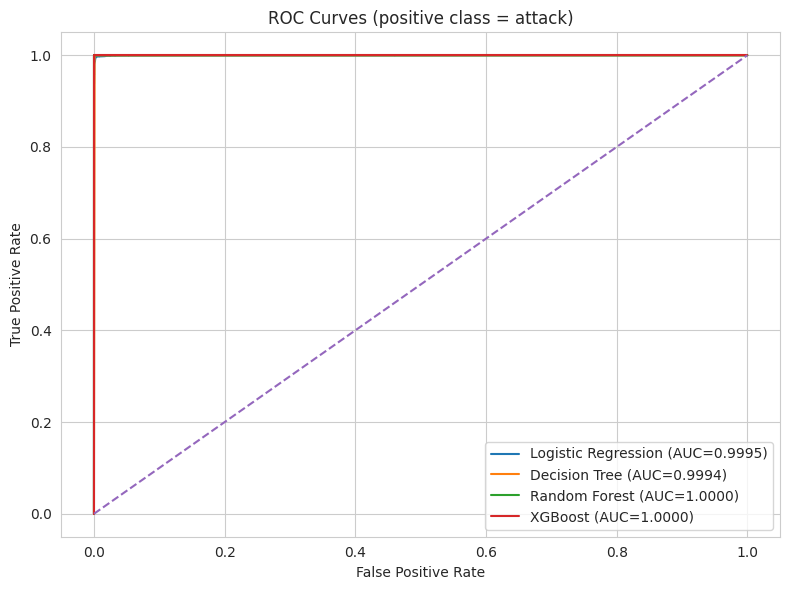

In [27]:
"""
ROC curves for 4 models on KDD'99-style dataset:
- Logistic Regression
- Decision Tree
- Random Forest
- XGBoost

Input:
  dataset.csv with column "Attack Type"
Output:
  roc_curves.png
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_curve, auc, roc_auc_score

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# ---------------- Data ----------------
df = pd.read_csv("/content/sample_data/dataset.csv", low_memory=False)
if "Unnamed: 0" in df.columns:
    df = df.drop(columns=["Unnamed: 0"])
df = df.rename(columns={"Attack Type": "target"})
df["target"] = df["target"].astype(str).str.lower().str.strip()
df["target"] = df["target"].apply(lambda x: "normal" if x == "normal" else "attack")

# Optional: quick run on a subset (comment this out for full dataset)
# df = df.sample(30000, random_state=42)

X = df.drop(columns=["target"])
y = df["target"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

# ---------------- Preprocessing ----------------
cat_cols = [c for c in X.columns if X[c].dtype == "object"]
num_cols = [c for c in X.columns if c not in cat_cols]

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(with_mean=False), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ],
    remainder="drop",
    verbose_feature_names_out=False,
)

# ---------------- Models ----------------
models = {
    "Logistic Regression": Pipeline([
        ("prep", preprocessor),
        ("clf", LogisticRegression(max_iter=1000, class_weight="balanced", solver="saga", n_jobs=-1)),
    ]),
    "Decision Tree": Pipeline([
        ("prep", preprocessor),
        ("clf", DecisionTreeClassifier(random_state=42, class_weight="balanced")),
    ]),
    "Random Forest": Pipeline([
        ("prep", preprocessor),
        ("clf", RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1,
                                      class_weight="balanced_subsample")),
    ]),
}

# XGBoost requires numeric labels for training
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)   # "attack"/"normal" -> 0/1 (order decided by encoder)
y_test_enc = le.transform(y_test)
models["XGBoost"] = Pipeline([
    ("prep", preprocessor),
    ("clf", XGBClassifier(use_label_encoder=False, eval_metric="logloss",
                          n_estimators=300, max_depth=8, subsample=0.9,
                          colsample_bytree=0.9, n_jobs=-1, random_state=42)),
])

# ---------------- Train & ROC ----------------
curves = {}   # name -> (fpr, tpr, auc)
y_true01 = (y_test == "attack").astype(int).values
for name, pipe in models.items():
    if name == "XGBoost":
        pipe.fit(X_train, y_train_enc)
        proba = pipe.predict_proba(X_test)
        # map to "attack" probability using label encoder
        attack_code = int(le.transform(["attack"])[0])
        y_prob = proba[:, attack_code]
    else:
        pipe.fit(X_train, y_train)
        proba = pipe.predict_proba(X_test)
        # proba columns correspond to pipe[-1].classes_ (strings)
        pos_idx = list(pipe[-1].classes_).index("attack")
        y_prob = proba[:, pos_idx]

    fpr, tpr, _ = roc_curve(y_true01, y_prob)
    auc_val = auc(fpr, tpr)
    curves[name] = (fpr, tpr, auc_val)

# ---------------- Plot ----------------
plt.figure(figsize=(8, 6))
for name, (fpr, tpr, auc_val) in curves.items():
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc_val:.4f})")

plt.plot([0, 1], [0, 1], linestyle="--")
plt.title("ROC Curves (positive class = attack)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig("roc_curves.png", dpi=150)
plt.show()

# Accuracy in tabular format

In [ ]:
"""
Train 4 models on KDD'99-style CSV and produce:
1) Accuracy table
2) Bar chart of accuracies
3) Pairwise Accuracy Differences (percentage points)

Input:
  - dataset.csv
    expects a label column named "Attack Type" with values like "normal", "dos", etc.

Outputs:
  - results_metrics.csv
  - model_accuracies_table.csv
  - pairwise_accuracy_differences_pp.csv
  - accuracies_bar.png
"""

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier


# ----------------------------- Config ---------------------------------
DATA_PATH = "/content/sample_data/dataset.csv"       
TEST_SIZE = 0.20
RANDOM_STATE = 42
SUBSAMPLE_N = None              # e.g., 50000 for quicker local tests; None = use full data

# Model configs (tweak if you want)
CFG_LOGREG = dict(max_iter=1000, class_weight="balanced", solver="saga", n_jobs=-1)
CFG_DT     = dict(random_state=RANDOM_STATE, class_weight="balanced", max_depth=None)
CFG_RF     = dict(n_estimators=200, random_state=RANDOM_STATE, n_jobs=-1, class_weight="balanced_subsample")
CFG_XGB    = dict(
    use_label_encoder=False, eval_metric="logloss",
    n_estimators=300, max_depth=8, subsample=0.9, colsample_bytree=0.9,
    learning_rate=0.1, n_jobs=-1, random_state=RANDOM_STATE
)
# ----------------------------------------------------------------------


def load_and_prepare(path: str, subsample_n: int | None):
    df = pd.read_csv(path, low_memory=False)
    # Drop common index-ish columns if present
    for c in ["Unnamed: 0", "index"]:
        if c in df.columns:
            df = df.drop(columns=[c])

    # Standardize target
    if "Attack Type" not in df.columns:
        raise ValueError("Expected a label column named 'Attack Type'.")

    df = df.rename(columns={"Attack Type": "target"})
    df["target"] = df["target"].astype(str).str.lower().str.strip()
    # Binary target: normal vs attack (everything else)
    df["target"] = df["target"].apply(lambda x: "normal" if x == "normal" else "attack")

    if subsample_n is not None and subsample_n < len(df):
        df = df.sample(subsample_n, random_state=RANDOM_STATE)

    X = df.drop(columns=["target"])
    y = df["target"].copy()

    # Identify categorical columns (object dtype)
    cat_cols = [c for c in X.columns if X[c].dtype == "object"]
    num_cols = [c for c in X.columns if c not in cat_cols]

    preprocessor = ColumnTransformer(
        transformers=[
            ("num", StandardScaler(with_mean=False), num_cols),
            ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
        ],
        remainder="drop",
        verbose_feature_names_out=False,
    )
    return X, y, preprocessor


def train_and_eval(X, y, preprocessor):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
    )

    results = []

    # Logistic Regression
    logreg = Pipeline([("prep", preprocessor), ("clf", LogisticRegression(**CFG_LOGREG))])
    logreg.fit(X_train, y_train)
    pred = logreg.predict(X_test)
    results.append(("Logistic Regression", accuracy_score(y_test, pred)))

    # Decision Tree
    dt = Pipeline([("prep", preprocessor), ("clf", DecisionTreeClassifier(**CFG_DT))])
    dt.fit(X_train, y_train)
    pred = dt.predict(X_test)
    results.append(("Decision Tree", accuracy_score(y_test, pred)))

    # Random Forest
    rf = Pipeline([("prep", preprocessor), ("clf", RandomForestClassifier(**CFG_RF))])
    rf.fit(X_train, y_train)
    pred = rf.predict(X_test)
    results.append(("Random Forest", accuracy_score(y_test, pred)))

    # XGBoost needs integer labels; we’ll wrap just the y in a LabelEncoder
    le = LabelEncoder()
    y_train_enc = le.fit_transform(y_train)
    y_test_enc = le.transform(y_test)

    xgb = Pipeline([("prep", preprocessor), ("clf", XGBClassifier(**CFG_XGB))])
    xgb.fit(X_train, y_train_enc)
    pred_enc = xgb.predict(X_test)
    # Convert back to original string labels (normal/attack)
    pred = le.inverse_transform(pred_enc)
    results.append(("XGBoost", accuracy_score(y_test, pred)))

    # Build results DataFrame
    acc_df = pd.DataFrame(results, columns=["Model", "Accuracy"])
    acc_df["Accuracy (%)]"] = (acc_df["Accuracy"] * 100).round(4)

    return acc_df.set_index("Model")


def pairwise_pp(acc_df: pd.DataFrame) -> pd.DataFrame:
    """Pairwise accuracy differences in percentage points (A - B, in pp)."""
    acc_pp = (acc_df["Accuracy"] * 100.0)
    models = acc_pp.index.tolist()
    diff = pd.DataFrame(index=models, columns=models, dtype=float)

    for a in models:
        for b in models:
            diff.loc[a, b] = round(acc_pp[a] - acc_pp[b], 4)

    diff.index.name = "Model (Row) minus Model (Col)"
    return diff


def plot_accuracies(acc_df: pd.DataFrame, out_path="accurities_bar.png"):
    plt.figure(figsize=(8, 4.5))
    plt.bar(acc_df.index, (acc_df["Accuracy"] * 100.0))
    plt.title("Model Accuracies")
    plt.xlabel("Model")
    plt.ylabel("Accuracy (%)")
    plt.xticks(rotation=20, ha="right")
    plt.tight_layout()
    plt.savefig(out_path, dpi=150)
    plt.close()


def main():
    X, y, preprocessor = load_and_prepare(DATA_PATH, SUBSAMPLE_N)
    acc_df = train_and_eval(X, y, preprocessor)

    # Save tables
    acc_df_out = acc_df.copy()
    acc_df_out["Accuracy (%)"] = (acc_df_out["Accuracy"] * 100).round(4)
    acc_df_out.to_csv("model_accuracies_table.csv")

    pp_diff = pairwise_pp(acc_df)
    pp_diff.to_csv("pairwise_accuracy_differences_pp.csv")

    # Simple metrics file
    acc_df_out.rename_axis("Model").to_csv("results_metrics.csv")

    # Plot
    plot_accuracies(acc_df, out_path="accuracies_bar.png")

    print("\n== Accuracy Table ==")
    print(acc_df_out[["Accuracy", "Accuracy (%)"]])


if __name__ == "__main__":
    main()


== Accuracy Table ==
                     Accuracy  Accuracy (%)
Model                                      
Logistic Regression  0.995496       99.5496
Decision Tree        0.999626       99.9626
Random Forest        0.999787       99.9787
XGBoost              0.999848       99.9848


# Visualizations for model performance metrics

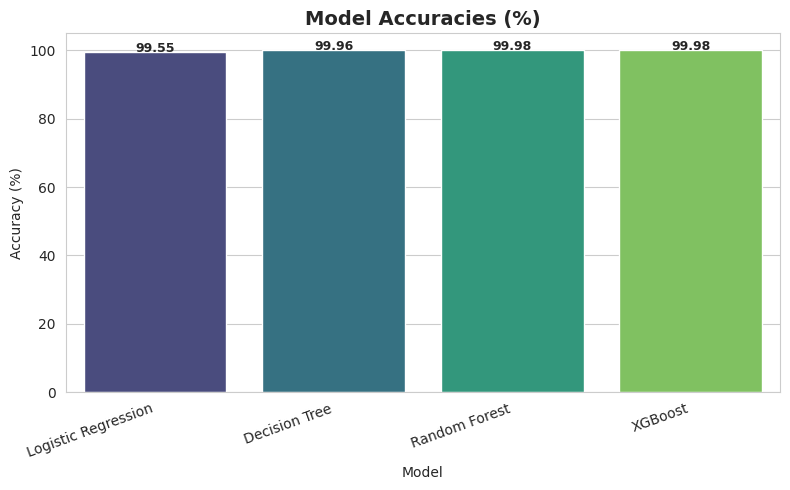

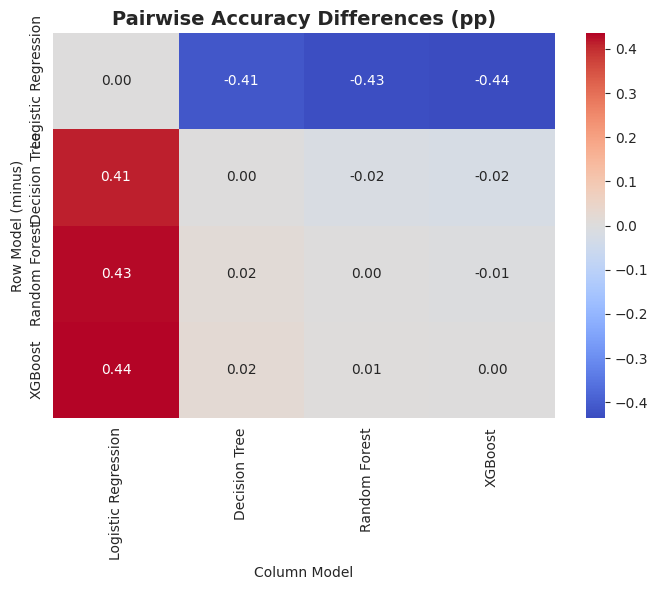

In [29]:
"""
Visualizations for model performance metrics.

Outputs:
- accuracies_bar.png
- pairwise_heatmap.png
- results_metrics_plot.png
"""

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ----------------- Load CSVs -----------------
acc_df = pd.read_csv("model_accuracies_table.csv")
pp_diff_df = pd.read_csv("pairwise_accuracy_differences_pp.csv", index_col=0)
results_df = pd.read_csv("results_metrics.csv")

# ----------------- 1. Accuracy table -----------------
plt.figure(figsize=(8,5))
sns.barplot(x="Model", y="Accuracy (%)", data=acc_df, palette="viridis")
plt.title("Model Accuracies (%)", fontsize=14, weight="bold")
plt.ylabel("Accuracy (%)")
plt.xticks(rotation=20, ha="right")
for i, v in enumerate(acc_df["Accuracy (%)"]):
    plt.text(i, v + 0.1, f"{v:.2f}", ha="center", fontsize=9, fontweight="bold")
plt.tight_layout()
plt.savefig("model_accuracies_table_plot.png", dpi=150)
plt.show()

# ----------------- 2. Pairwise accuracy differences (heatmap) -----------------
plt.figure(figsize=(7,6))
sns.heatmap(pp_diff_df.astype(float), annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("Pairwise Accuracy Differences (pp)", fontsize=14, weight="bold")
plt.ylabel("Row Model (minus)")
plt.xlabel("Column Model")
plt.tight_layout()
plt.savefig("pairwise_heatmap.png", dpi=150)
plt.show()


#  MSE, R(Pearson), R² by Model

                 Model       MSE  R (Pearson)        R²
0  Logistic Regression  0.000179     0.999520  0.998882
2        Random Forest  0.001216     0.996321  0.992400
1        Decision Tree  0.005000     0.984638  0.968750
3              XGBoost  0.009348     0.990961  0.941577


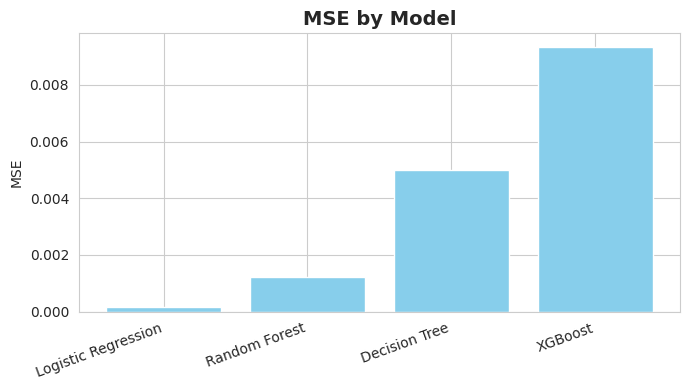

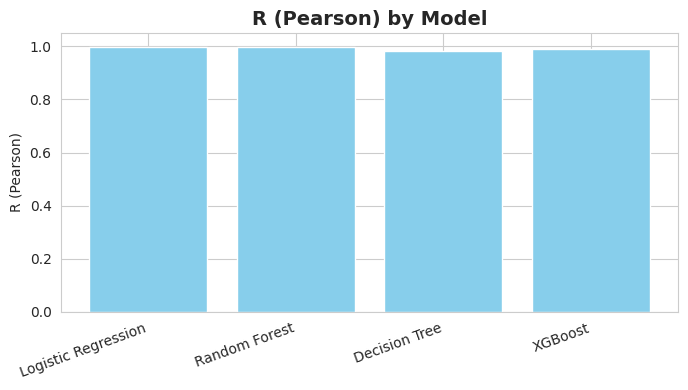

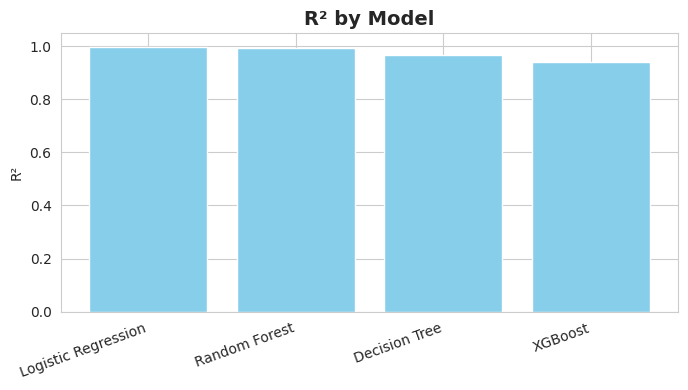

In [30]:
"""
Compute and visualize MSE, R (Pearson), and R² for four models:
- Logistic Regression
- Decision Tree
- Random Forest
- XGBoost

Input:
  dataset.csv with "Attack Type" column
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier


# ---------------- Data Prep ----------------
df = pd.read_csv("/content/sample_data/dataset.csv")
if "Unnamed: 0" in df.columns:
    df = df.drop(columns=["Unnamed: 0"])

df = df.rename(columns={"Attack Type": "target"})
df["target"] = df["target"].astype(str).str.lower().str.strip()
df["target"] = df["target"].apply(lambda x: "normal" if x == "normal" else "attack")

# Sample for speed (optional: remove if you want full dataset)
df = df.sample(1000, random_state=42)

X = df.drop(columns=["target"])
y = df["target"]
y01 = (y == "attack").astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
y_test01 = (y_test == "attack").astype(int)

cat_cols = [c for c in X.columns if X[c].dtype == "object"]
num_cols = [c for c in X.columns if c not in cat_cols]

preprocessor = ColumnTransformer([
    ("num", StandardScaler(with_mean=False), num_cols),
    ("cat", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1), cat_cols)
])


# ---------------- Helper ----------------
def mse_r_r2_from_pipe(pipe, X_test, y_test01, pos_label="attack"):
    proba = pipe.predict_proba(X_test)
    classes = pipe[-1].classes_
    pos_idx = list(classes).index(pos_label) if isinstance(classes[0], str) else 1
    y_prob = proba[:, pos_idx]
    mse = mean_squared_error(y_test01, y_prob)
    r2 = r2_score(y_test01, y_prob)
    R = float(np.corrcoef(y_test01, y_prob)[0, 1])
    return mse, R, r2


# ---------------- Train & Evaluate ----------------
results = []

# Logistic Regression
log_reg = Pipeline([
    ("prep", preprocessor),
    ("clf", LogisticRegression(max_iter=200, class_weight="balanced", solver="liblinear"))
])
log_reg.fit(X_train, y_train)
results.append(("Logistic Regression",) + mse_r_r2_from_pipe(log_reg, X_test, y_test01))

# Decision Tree
dt = Pipeline([
    ("prep", preprocessor),
    ("clf", DecisionTreeClassifier(random_state=42, class_weight="balanced", max_depth=8))
])
dt.fit(X_train, y_train)
results.append(("Decision Tree",) + mse_r_r2_from_pipe(dt, X_test, y_test01))

# Random Forest
rf = Pipeline([
    ("prep", preprocessor),
    ("clf", RandomForestClassifier(n_estimators=25, random_state=42, n_jobs=-1,
                                   class_weight="balanced_subsample", max_depth=10))
])
rf.fit(X_train, y_train)
results.append(("Random Forest",) + mse_r_r2_from_pipe(rf, X_test, y_test01))

# XGBoost
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
xgb = Pipeline([
    ("prep", preprocessor),
    ("clf", XGBClassifier(use_label_encoder=False, eval_metric="logloss",
                          n_estimators=5, max_depth=3, random_state=42))
])
xgb.fit(X_train, y_train_enc)
proba = xgb.predict_proba(X_test)
attack_code = int(le.transform(["attack"])[0])
y_prob_xgb = proba[:, attack_code]
mse = mean_squared_error(y_test01, y_prob_xgb)
r2 = r2_score(y_test01, y_prob_xgb)
R = float(np.corrcoef(y_test01, y_prob_xgb)[0, 1])
results.append(("XGBoost", mse, R, r2))


# ---------------- Results Table ----------------
res_df = pd.DataFrame(results, columns=["Model", "MSE", "R (Pearson)", "R²"]).sort_values("MSE")
print(res_df)

res_df.to_csv("mse_r_r2_results.csv", index=False)


# ---------------- Visualization ----------------
metrics = ["MSE", "R (Pearson)", "R²"]

for metric in metrics:
    plt.figure(figsize=(7, 4))
    plt.bar(res_df["Model"], res_df[metric], color="skyblue")
    plt.title(f"{metric} by Model", fontsize=14, weight="bold")
    plt.ylabel(metric)
    plt.xticks(rotation=20, ha="right")
    plt.tight_layout()
    plt.savefig(f"{metric.replace(' ', '_')}_plot.png", dpi=150)
    plt.show()

# OSINT Integration (ThreatMiner + OTX)

In [31]:
# 0) Install dependencies (run once per environment)
!pip -q install OTXv2 requests

In [ ]:
#import os
if 'OTX_API_KEY' not in os.environ:
    os.environ['OTX_API_KEY'] = 'PUT_YOUR_OTX_API_KEY_HERE'  

In [35]:
# 2) Imports
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

from osint_reputation import OSINTReputation

### 3) Build/Reuse core preprocessor + add OSINT features
This cell detects your numeric/categorical columns. If you already have `core_prep`, you can skip its creation.

In [36]:
# Expecting your data to be available as X, y, and maybe X_train/X_test/y_train/y_test
# If not, run your existing loading/splitting cells first.

try:
    core_prep
except NameError:
    # Auto-detect columns, excluding IOC indicator columns from core features
    ioc_cols = ['src_ip','dst_ip','domain','email','file_hash']
    existing_cols = list(X.columns)
    safe_cols = [c for c in existing_cols if c not in ioc_cols]
    cat_cols = [c for c in safe_cols if getattr(X[c], 'dtype', None) == 'object']
    num_cols = [c for c in safe_cols if c not in cat_cols]

    core_prep = ColumnTransformer([
        ("num", Pipeline([
            ("impute", SimpleImputer(strategy="median")),
            ("scale", StandardScaler(with_mean=False))
        ]), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
    ], remainder="drop")

feat_union = FeatureUnion([
    ("base", core_prep),
    ("osint", OSINTReputation(src_ip_col="src_ip", dst_ip_col="dst_ip"))
])

clf = LogisticRegression(max_iter=1000, class_weight="balanced", solver="saga")
osint_pipeline = Pipeline([("features", feat_union), ("clf", clf)])

### 4) Optional: OSINT Guard (post-prediction override)
Escalate any row to *attack* if its IPs are flagged by OSINT.

In [37]:
from osint_reputation import tm_query_host, otx_ip_details

def apply_osint_guard(y_pred: pd.Series, X_batch: pd.DataFrame,
                      tm_min_hits=1, otx_min_pulses=1):
    final = y_pred.copy()
    for i, row in X_batch.iterrows():
        hot = False
        for ip in [row.get("src_ip"), row.get("dst_ip")]:
            if isinstance(ip, str) and ip.strip():
                tm = tm_query_host(ip.strip(), rt=6)
                tm_results = tm.get("results", [])
                tm_hits = len(tm_results) if isinstance(tm_results, list) else (1 if tm_results else 0)

                otx = otx_ip_details(ip.strip())
                pulses = (otx.get("data", {}).get("pulse_info", {}) or {}).get("count", 0) if otx.get("ok") else 0

                if tm_hits >= tm_min_hits or pulses >= otx_min_pulses:
                    hot = True
                    break
        if hot and final.iloc[i] == "normal":
            final.iloc[i] = "attack"
    return final

### 5) Train + Evaluate with OSINT features
If dataset lacks `src_ip`/`dst_ip`, the OSINT features are zero and the model behaves as before (safe to run).

              precision    recall  f1-score   support

      attack       1.00      0.99      0.99       160
      normal       0.95      1.00      0.98        40

    accuracy                           0.99       200
   macro avg       0.98      0.99      0.98       200
weighted avg       0.99      0.99      0.99       200



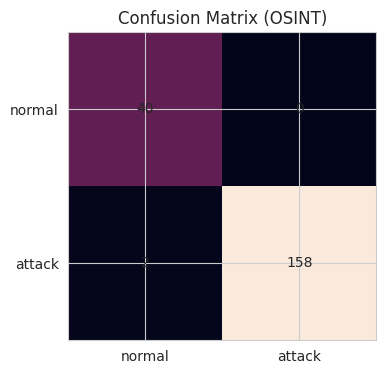

In [38]:
# Fit
osint_pipeline.fit(X_train, y_train)

# Predict
y_pred = pd.Series(osint_pipeline.predict(X_test), index=X_test.index)

# Optional: apply guard (comment out if not desired)
# y_pred = apply_osint_guard(y_pred, X_test)

print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred, labels=["normal","attack"])
fig, ax = plt.subplots(figsize=(4,4))
ax.imshow(cm)
ax.set_xticks([0,1]); ax.set_xticklabels(["normal","attack"])
ax.set_yticks([0,1]); ax.set_yticklabels(["normal","attack"])
for (i,j), v in np.ndenumerate(cm):
    ax.text(j, i, int(v), ha='center', va='center')
ax.set_title("Confusion Matrix (OSINT)")
plt.show()